In [1]:
from time import time
import psycopg2
from collections import Counter
import gc
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
np.set_printoptions(suppress=True,precision=10)

In [2]:
def cleanMatrix(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("DELETE "
                      " FROM matrix"
    )
    cur.execute(select_stament)
    conn.commit()
    cur.close()
    conn.close()

In [3]:
def selectWord(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = '''SELECT subject_id,word,isalive 
    FROM subjectwords 
    WHERE length(word)>1000 
    ''' #    ORDER BY isalive DESC 
        # LIMIT 400
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append({'subject_id':row[0],'word':row[1],'isalive':row[2]})
    conn.close()
    return select

In [4]:
def get_all_substrings(input_string,length=5):
    substrings = []
    for j in range(len(input_string)) :
        for i in range(length) :
            substrings.append(input_string[j:j+i+1])
    return Counter(substrings)

In [5]:
def saveMatrix(matrix,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    insert_statement=('INSERT INTO matrix(word,subject_id,counting)'
                      ' SELECT unnest( %(word)s ) ,'
                      ' unnest( %(subject_id)s) ,'
                      ' unnest( %(counting)s)')
    word=[r['word'] for r in matrix]
    subject_id=[r['subject_id'] for r in matrix]
    counting=[r['counting'] for r in matrix]
#    print(cur.mogrify(insert_statement,locals()))
    cur.execute(insert_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [6]:
def fillMatrix(length):
    cleanMatrix()
    i=0
    matrix = []
    for word in selectWord() :
        subject = word['subject_id']
        subs =get_all_substrings(word['word'],length=length)
        for key in subs:
            matrix.append({'word':key,'counting':subs[key],'subject_id':subject})
    saveMatrix(matrix)
    print("The matrix was filled with "+str(len(matrix))+" values.")

In [7]:
def fixMatrix(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("DELETE "
                      " FROM matrix"
                      " WHERE word in (SELECT word FROM matrix GROUP BY word HAVING sum(counting)<5)"
    )
    cur.execute(select_stament)
    select_stament = '''DELETE 
    FROM matrix 
    WHERE word IN (SELECT word FROM matrix group by word HAVING count(1)>=(
    SELECT count(distinct subject_id) FROM matrix))
    '''
    cur.execute(select_stament)
    conn.commit()
    cur.close()
    conn.close()

In [8]:
def selectMatrix(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT m.subject_id,m.word,m.counting,s.isalive "
                      " FROM matrix m LEFT JOIN subjectwords s ON m.subject_id=s.subject_id"
    )
    cur.execute(select_stament)
    select = []
    for row in cur :
        select.append((row))
    cur.close()
    conn.close()
    return select

In [9]:
def convertMatrix() :
    labels = ['subject_id', 'Word', 'Counting','isAlive']
    df = pd.DataFrame.from_records(selectMatrix(), columns=labels)
    print(len(df))
    return pd.pivot_table(df,index=["subject_id","isAlive"],columns=["Word"],values=["Counting"],
                       aggfunc={"Counting":[np.sum]},fill_value=0)

In [10]:
t0 = time()
fillMatrix(length=8)
print("fillMatrix done in %0.3fs." % (time() - t0))

The matrix was filled with 1151126 values.
fillMatrix done in 65.148s.


In [11]:
gc.collect()
t0 = time()
fixMatrix()
print("fixMatrix done in %0.3fs." % (time() - t0))
gc.collect()
t0 = time()
table = convertMatrix()
print("converMatrix done in %0.3fs." % (time() - t0))
print(table.shape)
gc.collect()

fixMatrix done in 30.468s.
1003792
converMatrix done in 15.922s.
(584, 29643)


14

In [12]:
survived = table.index.labels[1].tolist()
patients = table.values

In [13]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [14]:
print(table.shape)
print(patients_train.shape)
print(patients_test.shape)

(584, 29643)
(467, 29643)
(117, 29643)


### Base Model All Will Die

In [15]:
def base_rate_model(X) :
    y = np.zeros(X.shape[0])
    return y

In [16]:
y_base_rate = base_rate_model(patients_test)
print("Base rate acurracy is %2.2f" % accuracy_score(survived_test,base_rate_model(patients_test)))

Base rate acurracy is 0.38


### Direct Regresion Logistic

In [17]:
model = LogisticRegression(penalty='l2',C=2,class_weight="balanced")
model.fit(patients_train,survived_train)

LogisticRegression(C=2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [18]:
print("Logistic Regression acurracy is %2.2f" % accuracy_score(survived_test,model.predict(patients_test)))

Logistic Regression acurracy is 0.61


### NMF + Logistic Regression accurancy

In [19]:
def generateNMF(patients_train,survived_train,patients_test,n_components=30) :
    nmf = NMF(n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5)
    W = nmf.fit_transform(patients_train)
    H = nmf.components_
    modelnmf = LogisticRegression(penalty='l2',C=2,class_weight="balanced")
    modelnmf.fit(W,survived_train)
#    if(patients_test.shape[0]<=n_components) :
    patients_testnmf = nmf.transform(patients_test)
#    else :
#        patients_testnmf = nmf.fit_transform(patients_test)
    return modelnmf,patients_testnmf

In [21]:
modelnmf60,pat_testnmf60 = generateNMF(patients_train,survived_train,patients_test,n_components=60)
print("Non Negative Matrix Logistic acurracy is %2.2f" % accuracy_score(survived_test,modelnmf60.predict(pat_testnmf60)))

Non Negative Matrix Logistic acurracy is 0.56


In [22]:
modelnmf90,pat_testnmf90 = generateNMF(patients_train,survived_train,patients_test,n_components=90)
print("Non Negative Matrix Logistic acurracy is %2.2f" % accuracy_score(survived_test,modelnmf90.predict(pat_testnmf90)))

Non Negative Matrix Logistic acurracy is 0.52


In [23]:
modelnmf105,pat_testnmf105 = generateNMF(patients_train,survived_train,patients_test,n_components=105)
print("Non Negative Matrix Logistic acurracy is %2.2f" % accuracy_score(survived_test,modelnmf105.predict(pat_testnmf105)))

Non Negative Matrix Logistic acurracy is 0.55


In [24]:
modelnmf120,pat_testnmf120 = generateNMF(patients_train,survived_train,patients_test,n_components=120)
print("Non Negative Matrix Logistic acurracy is %2.2f" % accuracy_score(survived_test,modelnmf120.predict(pat_testnmf120)))

Non Negative Matrix Logistic acurracy is 0.53


In [25]:
modelnmf75,pat_testnmf75 = generateNMF(patients_train,survived_train,patients_test,n_components=75)
print("Non Negative Matrix Logistic acurracy is %2.2f" % accuracy_score(survived_test,modelnmf75.predict(pat_testnmf75)))

Non Negative Matrix Logistic acurracy is 0.55


### AUC

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [54]:
def aucModel(name,survived_test,model,patients_test):
    logit_roc_auc = roc_auc_score(survived_test,model.predict(patients_test))
    print(name+" AUC = %2.2f2f"% logit_roc_auc,end=" ")
    return logit_roc_auc

In [ ]:
accuracyScore,bestScore,nmf_roc_auc = 0,0,0
for x in range(1, 80):
    modelnmfNew,pat_testnmfNew = generateNMF(patients_train,survived_train,patients_test,n_components=x)
    newAccuracy = accuracy_score(survived_test,modelnmfNew.predict(pat_testnmfNew))
    newroc_auc = aucModel("NMF "+str(x),survived_test,modelnmfNew,pat_testnmfNew)
    if newroc_auc>nmf_roc_auc:
        modelnmf,pat_testnmf=modelnmfNew,pat_testnmfNew
        accuracyScore,bestScore,nmf_roc_auc=newAccuracy,x,newroc_auc
    print(" acurracy is %2.2f" % newAccuracy)
print("bestScore"+str(bestScore)+" accurracy is %2.2f"% accuracyScore)
print(classification_report(survived_test,modelnmf.predict(pat_testnmf)))

NMF 1 AUC = 0.472f  acurracy is 0.48
NMF 2 AUC = 0.472f  acurracy is 0.47
NMF 3 AUC = 0.402f  acurracy is 0.36
NMF 4 AUC = 0.542f  acurracy is 0.52
NMF 5 AUC = 0.522f  acurracy is 0.49
NMF 6 AUC = 0.472f  acurracy is 0.42
NMF 7 AUC = 0.472f  acurracy is 0.42
NMF 8 AUC = 0.502f  acurracy is 0.46
NMF 9 AUC = 0.482f  acurracy is 0.45
NMF 10 AUC = 0.552f  acurracy is 0.54
NMF 11 AUC = 0.522f  acurracy is 0.50
NMF 12 AUC = 0.522f  acurracy is 0.50
NMF 13 AUC = 0.502f  acurracy is 0.49
NMF 14 AUC = 0.542f  acurracy is 0.53
NMF 15 AUC = 0.542f  acurracy is 0.52
NMF 16 AUC = 0.542f  acurracy is 0.52
NMF 17 AUC = 0.532f  acurracy is 0.51
NMF 18 AUC = 0.552f  acurracy is 0.54
NMF 19 AUC = 0.532f  acurracy is 0.52
NMF 20 AUC = 0.542f  acurracy is 0.52
NMF 21 AUC = 0.522f  acurracy is 0.50
NMF 22 AUC = 0.522f  acurracy is 0.50
NMF 23 AUC = 0.512f  acurracy is 0.50


In [49]:
base_roc_auc = roc_auc_score(survived_test,base_rate_model(patients_test))
print("Base Rate AUC = %2.2f2f"% base_roc_auc)
print(classification_report(survived_test,base_rate_model(patients_test)))
logit_roc_auc = aucModel("Logistic",survived_test,model,patients_test)
nmf30_roc_auc = aucModel("NMF 30",survived_test,modelnmf30,pat_testnmf30)
nmf60_roc_auc = aucModel("NMF 60",survived_test,modelnmf60,pat_testnmf60)
nmf90_roc_auc = aucModel("NMF 90",survived_test,modelnmf90,pat_testnmf90)
nmf120_roc_auc = aucModel("NMF 120",survived_test,modelnmf120,pat_testnmf120)
nmf75_roc_auc = aucModel("NMF 75",survived_test,modelnmf75,pat_testnmf75)


Base Rate AUC = 0.502f
             precision    recall  f1-score   support

          0       0.38      1.00      0.56        45
          1       0.00      0.00      0.00        72

avg / total       0.15      0.38      0.21       117

Logistic Model
Logistic AUC = 0.612f
             precision    recall  f1-score   support

          0       0.49      0.62      0.55        45
          1       0.72      0.60      0.65        72

avg / total       0.63      0.61      0.61       117

NMF 30 Model
NMF 30 AUC = 0.522f
             precision    recall  f1-score   support

          0       0.41      0.44      0.43        45
          1       0.63      0.60      0.61        72

avg / total       0.55      0.54      0.54       117

NMF 60 Model
NMF 60 AUC = 0.572f
             precision    recall  f1-score   support

          0       0.44      0.62      0.52        45
          1       0.69      0.51      0.59        72

avg / total       0.59      0.56      0.56       117

NMF 90 Model
N

/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [30]:
def roc_curveplot(name,survived_test,model,patients_test,logit_roc_auc):
    fpr, tpr, thresholds = roc_curve(survived_test,model.predict_proba(patients_test)[:,1])
    plt.plot(fpr,tpr,label='ROC '+name+' curve (area =%0.2f)' % logit_roc_auc)

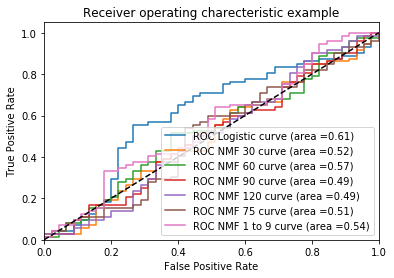

In [50]:
plt.figure()
roc_curveplot('Logistic',survived_test,model,patients_test,logit_roc_auc)
roc_curveplot('NMF 30',survived_test,modelnmf30,pat_testnmf30,nmf30_roc_auc)
roc_curveplot('NMF 60',survived_test,modelnmf60,pat_testnmf60,nmf60_roc_auc)
roc_curveplot('NMF 90',survived_test,modelnmf90,pat_testnmf90,nmf90_roc_auc)
roc_curveplot('NMF 120',survived_test,modelnmf120,pat_testnmf120,nmf120_roc_auc)
roc_curveplot('NMF 75',survived_test,modelnmf75,pat_testnmf75,nmf75_roc_auc)
roc_curveplot('NMF 1 to 9',survived_test,modelnmf,pat_testnmf,nmf1to9_roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating charecteristic example')
plt.legend(loc="lower right")
plt.show()